## Packages

In [41]:
import numpy as np
import random
import operator 
import pandas as pd 
import matplotlib.pyplot as plt
import math
from numba import autojit

## Create necessary functions

Create a fitness function

In [42]:
@autojit
def routeFitness(route, dm):
    dist = 0
    for i in range(len(route)-1):
        dist += dm[route[i], route[i+1]]
    dist += dm[int(route[-1]),int(route[0])]
    return 1/dist

In [43]:
#routeFitness(cities, d_matrix)

Create function to make matrix of distances

In [44]:
@autojit
def dist_matrix(df):
    list_of_distances = [] # just to make it simple, probably there are 1k better ways to do this
    for point in df.itertuples():
        a = point[1]
        b = point[2]
        for point_s in df.itertuples():
            c = point_s[1]
            d = point_s[2]
            dist = math.sqrt(((c-a)**2) + ((d-b)**2))
            list_of_distances.append(dist)
    dist_matrix = np.array(list_of_distances) # convertion to array
    dist_matrix = np.reshape(dist_matrix, (len(df), len(df))) # reshaping
    # dist_matrix.shape # check
    return dist_matrix

## Create our initial population

In [45]:
# def createRoute(cities):
#     route = random.sample(cities, len(cities))
#     return route

Create first "population" (list of routes)

In [104]:
def initPopulation(popSize, cities):
    population = []
    [population.append(random.sample(cities, len(cities))) for i in range(0, popSize)]
#     for i in range(0, popSize):
#         population.append(createRoute(cityList))
    return population

In [105]:
#pop = initPopulation(3, cities)

## Create the genetic algorithm

Rank individuals

In [106]:
def rankRoutes(population, dm):
    fitness = {}
    
    [fitness.update({i:routeFitness(population[i], dm)}) for i in range(0,len(population))]
#     for i in range(0,len(population)):
#         # fitnessResults[i] = Fitness(population[i], dm).routeFitness()
#         fitnessResults[i] = routeFitness(population[i], dm)
    return sorted(fitness.items(), key = operator.itemgetter(1), reverse = True)

In [107]:
#rankRoutes(pop, d_matrix)

Create a selection function that will be used to make the list of parent routes

In [131]:
def selection(popRanked, elite_n):
    selectionR = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    [selectionR.append(popRanked[i][0]) for i in range(0, elite_n)]
#     for i in range(0, eliteSize):
#         selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - elite_n):
        epsilon = 100*random.random()
        for i in range(0, len(popRanked)):
            if epsilon <= df.iat[i,3]:
                selectionR.append(popRanked[i][0])
                break
    return selectionR

Create mating pool

In [109]:
@autojit
def matingPool(population, selectionR):
    mp = []
    for i in range(0, len(selectionR)):
        index = selectionR[i]
        mp.append(population[index])
    return mp

Create a crossover function for two parents to create one child

In [110]:
def cross(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    
    [childP1.append(parent1[i]) for i in range(startGene, endGene)]
#     for i in range(startGene, endGene):
#         childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [111]:
def breedPopulation(mp, elite_n):
    children = []
    length = len(mp) - elite_n
    pool = random.sample(mp, len(mp))
    
    [children.append(mp[i]) for i in range(0,elite_n)]
#     for i in range(0,eliteSize):
#         children.append(matingpool[i])
    
    for i in range(0, length):
            child = cross(pool[i], pool[len(mp)-i-1])
            children.append(child)
    return children

Create function to mutate a single route

In [112]:
@autojit
def mutation(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [113]:
@autojit
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutation(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [114]:
@autojit
def nextGen(currentGen, elite_n, mutationRate, dm):
    popRanked = rankRoutes(currentGen, dm)
    selectionR = selection(popRanked, elite_n)
    mp = matingPool(currentGen, selectionR)
    children = breedPopulation(mp, elite_n)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [115]:
@autojit
def GenA(permutation, dm, popSize, elite_n, mutation_r, n_of_gen):
    pop = initPopulation(popSize, permutation)
    print("Initial distance: " + str(1 / rankRoutes(pop, dm)[0][1]))
    
    for i in range(0, n_of_gen):
        pop = nextGen(pop, elite_n, mutation_r, dm)
    
    print("Final distance: " + str(1 / rankRoutes(pop, dm)[0][1]))
    bestRouteIndex = rankRoutes(pop, dm)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

Import our data

In [116]:
df = pd.read_csv("berlin52.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df.head()

,x,y
1,565.0,575.0
2,25.0,185.0
3,345.0,750.0
4,945.0,685.0
5,845.0,655.0


Create the list of cities and the matrix of distances

In [117]:
cities = []
cities = list(range(len(df)))
d_matrix = dist_matrix(df)

Run the genetic algorithm

In [147]:
%time GenA(permutation = cities,dm = d_matrix,popSize = 70,elite_n = 15, \
           mutation_r = 0.01, n_of_gen = 300) \
     


Initial distance: 23346.980504149917
Final distance: 11693.824951955725
Wall time: 3.28 s


[19,
 22,
 6,
 1,
 41,
 16,
 30,
 47,
 5,
 37,
 36,
 38,
 33,
 35,
 34,
 21,
 31,
 48,
 39,
 43,
 0,
 2,
 44,
 18,
 7,
 9,
 40,
 8,
 32,
 42,
 50,
 10,
 51,
 13,
 46,
 26,
 12,
 11,
 24,
 3,
 45,
 27,
 25,
 14,
 4,
 23,
 49,
 28,
 15,
 17,
 20,
 29]

In [23]:
#%time geneticAlgorithm(population = cityList, popSize = 100, eliteSize = 25, mutationRate = 0.01, generations = 100, dm = d_matrix)

## Plot the progress

Note, this will win run a separate GA

In [99]:
def geneticAlgorithmPlot(permutations, popSize, eliteSize, mutationRate, generations, dm = d_matrix):
    pop = initPopulation(popSize, permutations)
    progress = []
    progress.append(1 / rankRoutes(pop, dm)[0][1])
    
    for i in range(0, generations):
        pop = nextGen(pop, eliteSize, mutationRate, dm)
        progress.append(1 / rankRoutes(pop, dm)[0][1])
        
    print("Final distance: " + str(min(progress)))
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    

Run the function with our assumptions to see how distance has improved in each generation

Final distance: 21725.795027108128


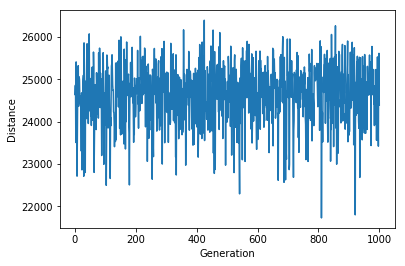

Wall time: 3min 40s


In [36]:
%time geneticAlgorithmPlot(permutations=cities, popSize=200, eliteSize=25, \
                           mutationRate=0.2, generations = 1000, \
                           dm = d_matrix) \